In [3]:
%run imports.py

Succesfully imported libraries and modules



In [4]:
p1 = load_patient(1)
p2 = load_patient(2)
p3 = load_patient(3)
p4 = load_patient(4)
p5 = load_patient(5)
p6 = load_patient(6)

Patient directory:  D:\LAB\AlexPAC\data\Patient1
Patient directory:  D:\LAB\AlexPAC\data\Patient2
Patient directory:  D:\LAB\AlexPAC\data\Patient3
Patient directory:  D:\LAB\AlexPAC\data\Patient4
Patient directory:  D:\LAB\AlexPAC\data\Patient5
Patient directory:  D:\LAB\AlexPAC\data\Patient6


In [7]:
conditions = [cond for cond in p3.conditions if "Rest 180sec" in cond]
placements = p3.sorted_placements

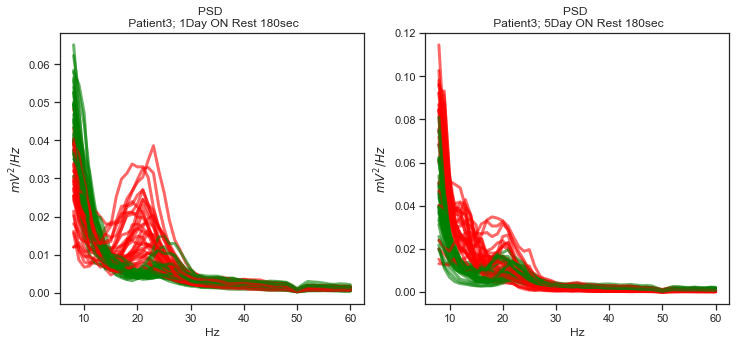

In [14]:
days = [1, 5]
ldopas = ["OFF", "ON"]
movement = "Rest 180sec"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, day in enumerate(days):
    ax = axes[i]
    for j, placement in enumerate(placements):
        for ldopa in ldopas:
            color = 'green' if ldopa == 'ON' else 'red'
            condition = create_condition_name(f"{day}Day", ldopa, movement)
            lfp = p3.lfp[condition][placement].normalize()
            lfp.show_psd((8, 60), smooth=False, sigma=1, ax=ax, log=False, color=color, linewidth=3, alpha=0.6)

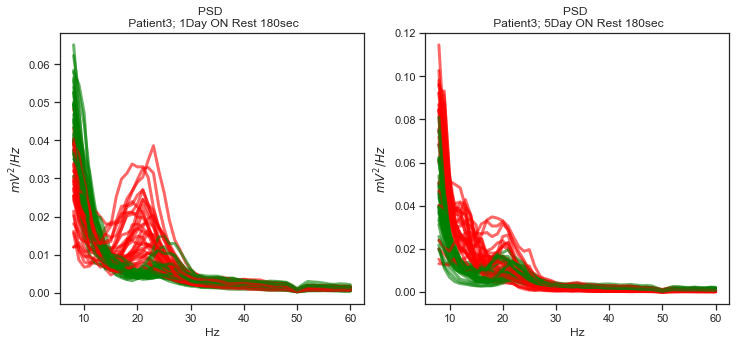

In [15]:
days = [1, 5]
ldopas = ["OFF", "ON"]
movement = "Rest 180sec"

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, day in enumerate(days):
    ax = axes[i]
    for j, placement in enumerate(placements):
        for ldopa in ldopas:
            color = 'green' if ldopa == 'ON' else 'red'
            condition = create_condition_name(f"{day}Day", ldopa, movement)
            lfp = p3.lfp[condition][placement]
            lfp.show_psd((8, 60), smooth=False, sigma=1, ax=ax, log=False, color=color, linewidth=3, alpha=0.6)

## LFP power in beta range with confidence intervals

1. Group LFPs by OFF/ON for each day for one patient
2. Group LFPs by OFF/ON for one patient (regardless of day)
3. Group LFPs by OFF/ON for all patients (regardless of patient)

In [14]:
def get_psd_array_by_day(patient, day, freqs=(8, 60), use_fooof=False, normalize=False):
    placements = patient.sorted_placements
    ldopas = ["OFF", "ON"]
    movement = "Rest 180sec"
    psd_array_off = []
    psd_array_on = []
    for j, placement in enumerate(placements):
        for ldopa in ldopas:
            condition = create_condition_name(f"{day}Day", ldopa, movement)
            lfp = patient.lfp[condition][placement]
            f, psd = lfp.get_psd()
            mask = (f >= freqs[0]) & (f <= freqs[1])
            f_new, psd_new = f[mask], psd[mask]
            if use_fooof:
                fm = FOOOF(peak_width_limits=(1, 12), max_n_peaks=5, peak_threshold=1, verbose=False)
                fm.fit(f_new, psd_new)
                psd_new = fm._peak_fit
            if normalize:
                psd_new = psd_new / np.sum(psd_new)
            if ldopa == 'OFF':
                psd_array_off.append(psd_new)
            if ldopa == 'ON':
                psd_array_on.append(psd_new)
    return f_new, np.array(psd_array_off), np.array(psd_array_on)

In [8]:
patient = p3
day = 1

f, psd_array_off, psd_array_on = get_psd_array_by_day(patient, day, use_fooof=True)

Text(0.5, 1.0, 'PSD; Patient3; Day 1')

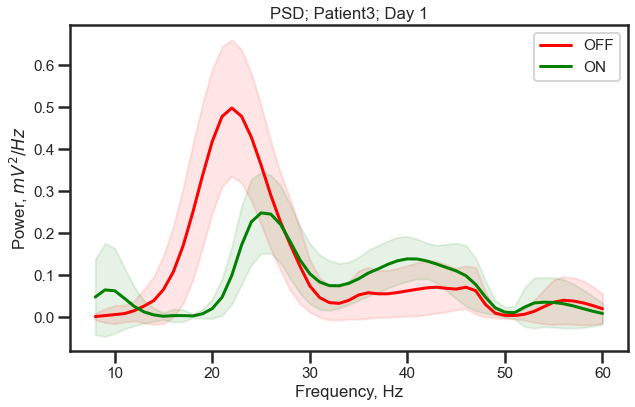

In [9]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')

psd_off_mean = psd_array_off.mean(axis=0)
psd_off_std = psd_array_off.std(axis=0)

psd_on_mean = psd_array_on.mean(axis=0)
psd_on_std = psd_array_on.std(axis=0)

freqs = (8, 60)
mask = (f >= 8) & (f <= 60)

fig, ax = plt.subplots()
ax.plot(f[mask], psd_off_mean[mask], color='red', label='OFF')
ax.fill_between(f[mask], psd_off_mean[mask] - psd_off_std[mask], psd_off_mean[mask] + psd_off_std[mask], color='red', alpha=.1)

ax.plot(f[mask], psd_on_mean[mask], color='green', label='ON')
ax.fill_between(f[mask], psd_on_mean[mask] - psd_on_std[mask], psd_on_mean[mask] + psd_on_std[mask], color='green', alpha=.1)


ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
ax.legend()
ax.set_title(f"PSD; {patient.name}; Day {day}")

### Loading patients

### Saving Patient + Day pictures

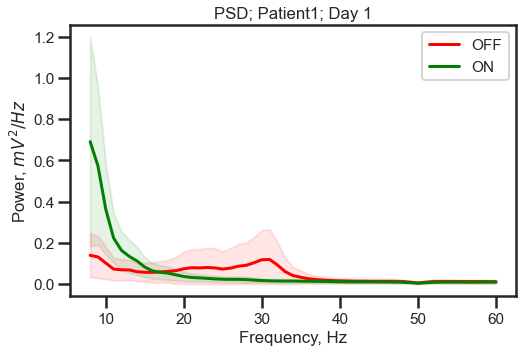

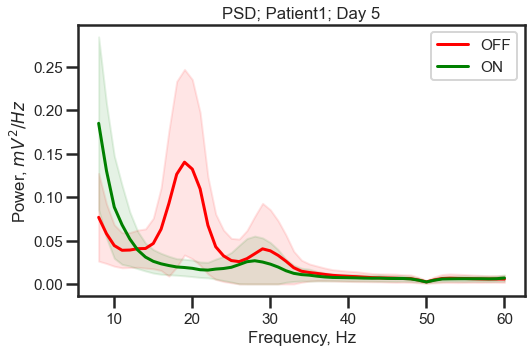

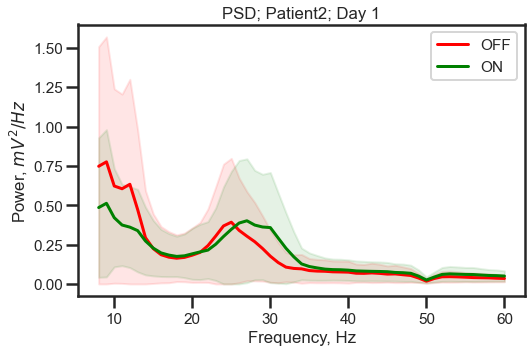

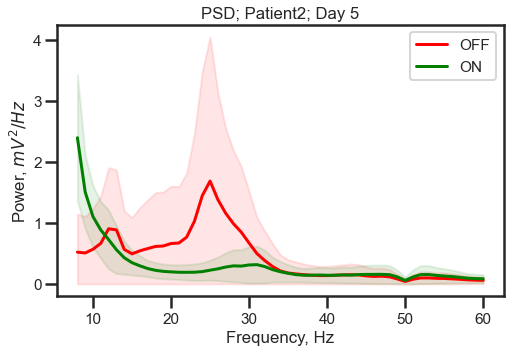

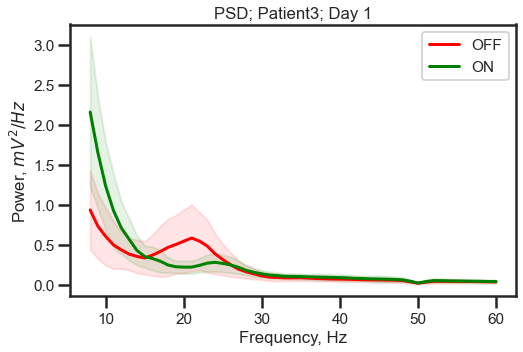

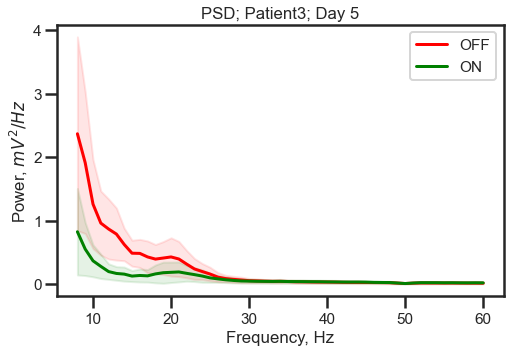

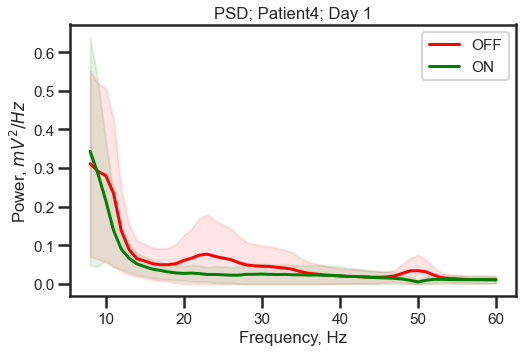

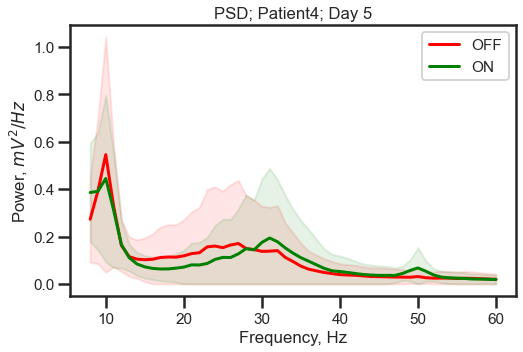

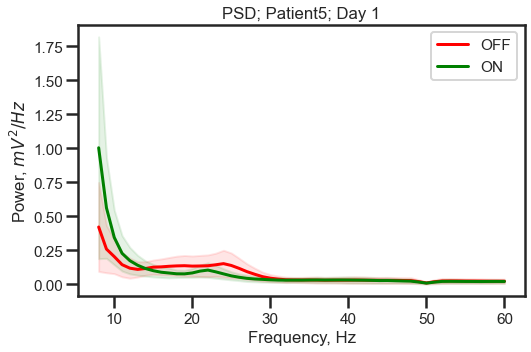

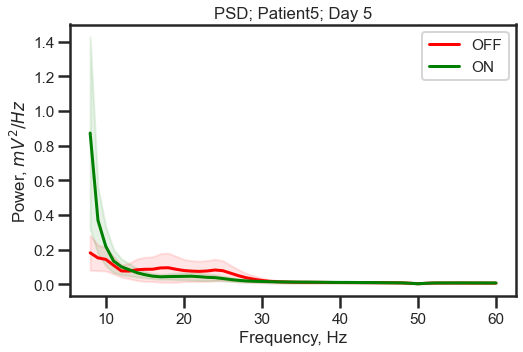

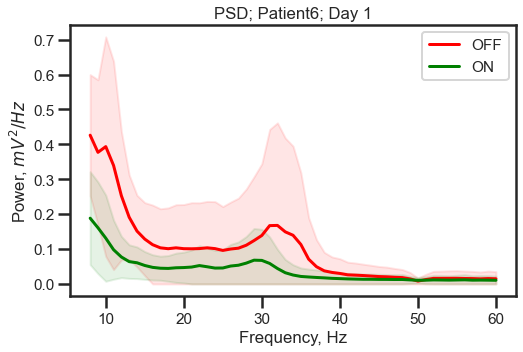

In [54]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON Beta by patient and day')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue
            
        f, psd_array_off, psd_array_on = get_psd_array_by_day(patient, day)
        psd_off_mean = psd_array_off.mean(axis=0)
        psd_off_std = psd_array_off.std(axis=0)

        psd_on_mean = psd_array_on.mean(axis=0)
        psd_on_std = psd_array_on.std(axis=0)

        freqs = (8, 60)
        mask = (f >= 8) & (f <= 60)

        fig, ax = plt.subplots(figsize=(8, 5))
        
        x = f[mask]
        y = psd_off_mean[mask]
        s = psd_off_std[mask]
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s
        
        ax.plot(x, y, color='red', label='OFF')
        ax.fill_between(x, lower, upper, color='red', alpha=.1)
        
        y = psd_on_mean[mask]
        s = psd_on_std[mask]
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s

        ax.plot(x, y, color='green', label='ON')
        ax.fill_between(x, lower, upper, color='green', alpha=.1)


        ax.set_xlabel("Frequency, Hz")
        ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
        ax.legend()
        ax.set_title(f"PSD; {patient.name}; Day {day}")

        fig_name = f"PSD OFF vs ON; {patient.name}; Day {day}.png"
        fig_path = os.path.join(save_path, fig_name)
        plt.savefig(fig_path, dpi=200, bbox_inches='tight')
        plt.show()

### Collective OFF vs ON (beta)

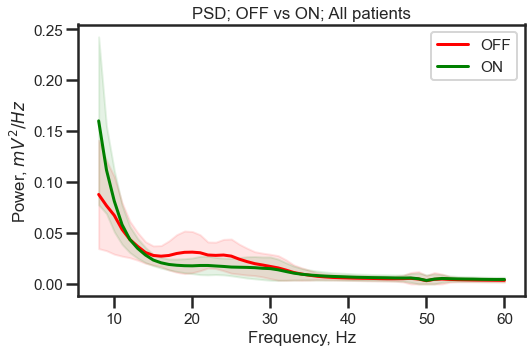

In [15]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as file:
    data_path = file.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON Beta all patients')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

psd_arrays_off = []
psd_arrays_on = []

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue 
        f, psd_array_off, psd_array_on = get_psd_array_by_day(patient, day, normalize=True)
        psd_arrays_off.append(psd_array_off)
        psd_arrays_on.append(psd_array_on)
        
psd_arrays_off = np.array(psd_arrays_off).reshape(-1, len(f))
psd_arrays_on = np.array(psd_arrays_on).reshape(-1, len(f))

f, _, _ = get_psd_array_by_day(p3, 1)

psd_off_mean = psd_arrays_off.mean(axis=0)
psd_off_std = psd_arrays_off.std(axis=0)

psd_on_mean = psd_arrays_on.mean(axis=0)
psd_on_std = psd_arrays_on.std(axis=0)

freqs = (8, 60)
mask = (f >= 8) & (f <= 60)

fig, ax = plt.subplots(figsize=(8, 5))
        
x = f[mask]
y = psd_off_mean[mask]
s = psd_off_std[mask]
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='red', label='OFF')
ax.fill_between(x, lower, upper, color='red', alpha=.1)

y = psd_on_mean[mask]
s = psd_on_std[mask]
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='green', label='ON')
ax.fill_between(x, lower, upper, color='green', alpha=.1)


ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
ax.legend()
ax.set_title(f"PSD; OFF vs ON; All patients")

fig_name = f"PSD OFF vs ON; All patients - normalized.png"
fig_path = os.path.join(save_path, fig_name)
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
plt.show()

## Whitened spectra

### For each patient separately

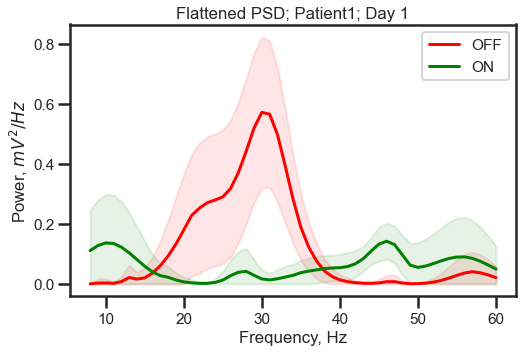

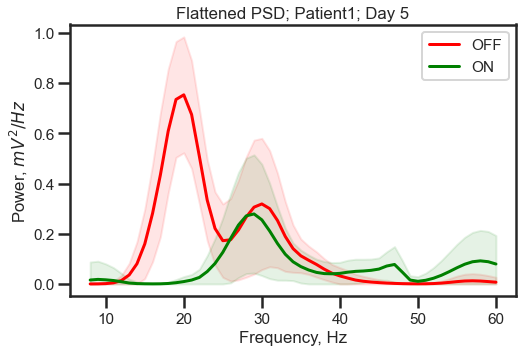

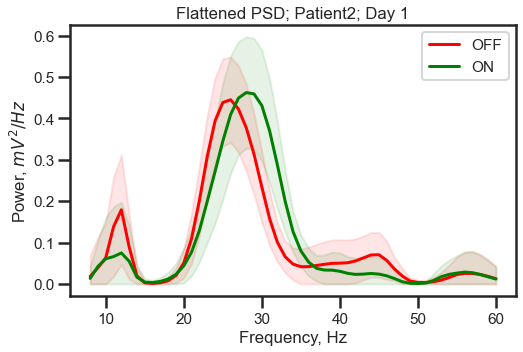

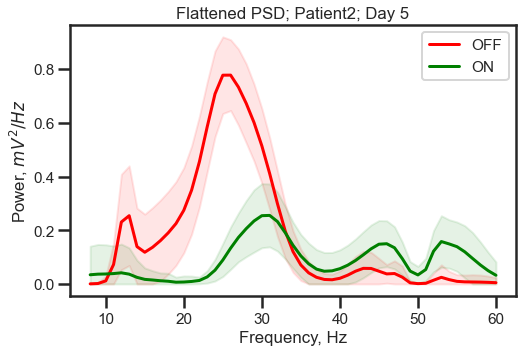

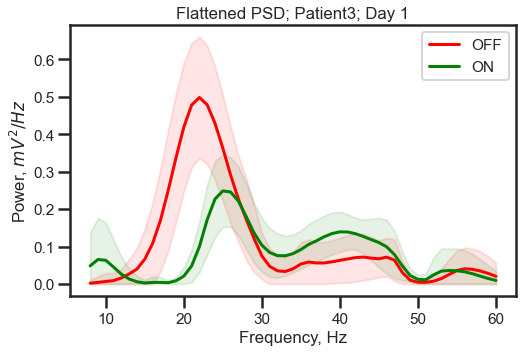

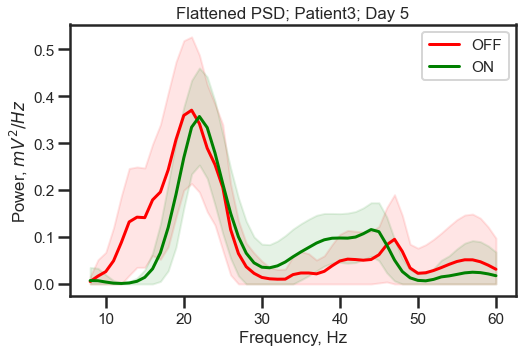

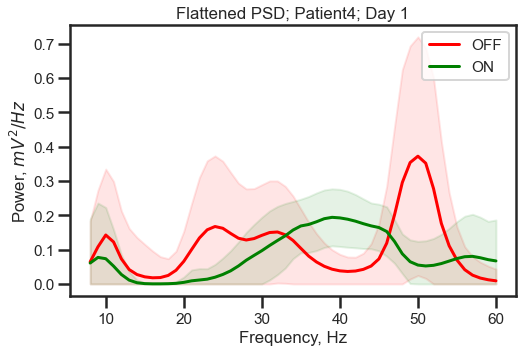

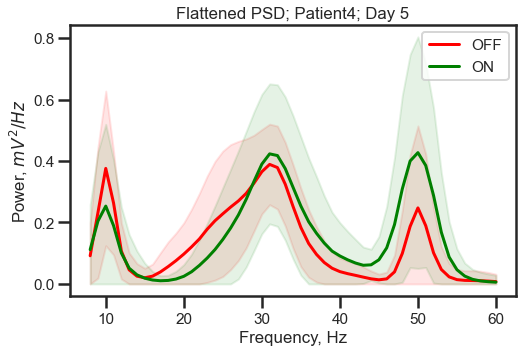

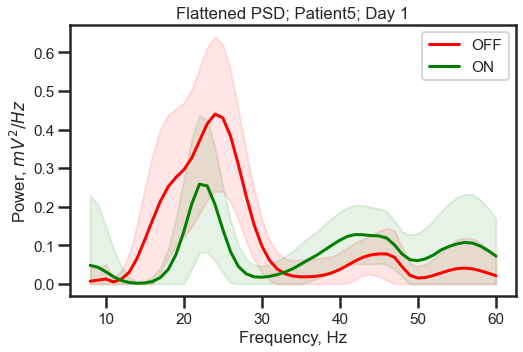

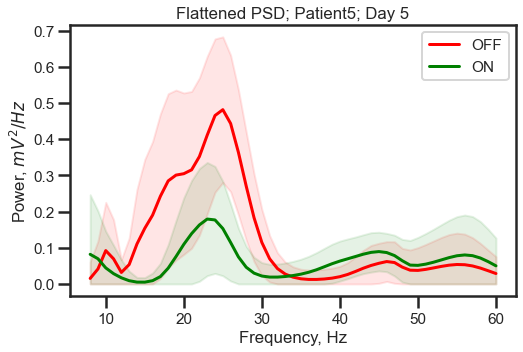

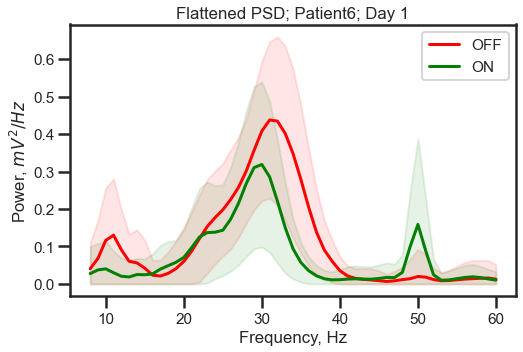

In [11]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON Beta by patient and day')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue
            
        f, psd_array_off, psd_array_on = get_psd_array_by_day(patient, day, use_fooof=True)
        psd_off_mean = psd_array_off.mean(axis=0)
        psd_off_std = psd_array_off.std(axis=0)

        psd_on_mean = psd_array_on.mean(axis=0)
        psd_on_std = psd_array_on.std(axis=0)

        freqs = (8, 60)
        mask = (f >= 8) & (f <= 60)

        fig, ax = plt.subplots(figsize=(8, 5))
        
        x = f[mask]
        y = psd_off_mean[mask]
        s = psd_off_std[mask]
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s
        
        ax.plot(x, y, color='red', label='OFF')
        ax.fill_between(x, lower, upper, color='red', alpha=.1)
        
        y = psd_on_mean[mask]
        s = psd_on_std[mask]
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s

        ax.plot(x, y, color='green', label='ON')
        ax.fill_between(x, lower, upper, color='green', alpha=.1)


        ax.set_xlabel("Frequency, Hz")
        ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
        ax.legend()
        ax.set_title(f"Flattened PSD; {patient.name}; Day {day}")

        fig_name = f"Flattened PSD OFF vs ON; {patient.name}; Day {day}.png"
        fig_path = os.path.join(save_path, fig_name)
        plt.savefig(fig_path, dpi=200, bbox_inches='tight')
        plt.show()

### Collective OFF vs ON (beta)

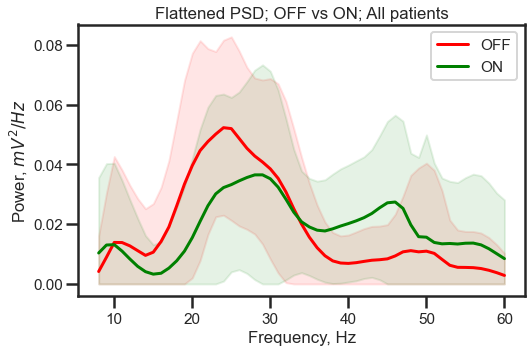

In [17]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as file:
    data_path = file.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON Beta all patients')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

psd_arrays_off = []
psd_arrays_on = []

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue 
        f, psd_array_off, psd_array_on = get_psd_array_by_day(patient, day, use_fooof=True, normalize=True)
        psd_arrays_off.append(psd_array_off)
        psd_arrays_on.append(psd_array_on)
        
psd_arrays_off = np.array(psd_arrays_off).reshape(-1, len(f))
psd_arrays_on = np.array(psd_arrays_on).reshape(-1, len(f))

f, _, _ = get_psd_array_by_day(p3, 1)

psd_off_mean = psd_arrays_off.mean(axis=0)
psd_off_std = psd_arrays_off.std(axis=0)

psd_on_mean = psd_arrays_on.mean(axis=0)
psd_on_std = psd_arrays_on.std(axis=0)

freqs = (8, 60)
mask = (f >= 8) & (f <= 60)

fig, ax = plt.subplots(figsize=(8, 5))
        
x = f[mask]
y = psd_off_mean[mask]
s = psd_off_std[mask]
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='red', label='OFF')
ax.fill_between(x, lower, upper, color='red', alpha=.1)

y = psd_on_mean[mask]
s = psd_on_std[mask]
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='green', label='ON')
ax.fill_between(x, lower, upper, color='green', alpha=.1)


ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
ax.legend()
ax.set_title(f"Flattened PSD; OFF vs ON; All patients")

fig_name = f"Flattened PSD OFF vs ON; All patients - normalized.png"
fig_path = os.path.join(save_path, fig_name)
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
plt.show()

## HFO spectra

In [18]:
for placement in p3.sorted_placements[::1]:
    
    lfp = p3.lfp[condition][placement]
    lfp_data = lfp.data.copy()
    lfp_data = lfp_data / np.std(lfp_data)

    lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)
    
    f, y = lfp_norm.get_psd(smooth=True, sigma=2)
    
    #y /= np.sum(y)

    mask = (f > 160) & (f < 500)
    
    f_hat, y_hat = f[mask], y[mask]
    y_hat -= np.min(y_hat)
    sigma=3
    y_hat = gaussian_filter1d(y_hat, sigma)

NameError: name 'condition' is not defined

In [19]:
def get_psd_hfo_array_by_day(patient, day, freqs=(160, 500)):
    placements = patient.sorted_placements
    ldopas = ["OFF", "ON"]
    movement = "Rest 180sec"
    psd_array_off = []
    psd_array_on = []
    for j, placement in enumerate(placements):
        for ldopa in ldopas:
            condition = create_condition_name(f"{day}Day", ldopa, movement)
            lfp = patient.lfp[condition][placement]
            f, psd = lfp.get_psd()
            mask = (f >= freqs[0]) & (f <= freqs[1])
            f_new, psd_new = f[mask], psd[mask]
            lfp = p3.lfp[condition][placement]
            lfp_data = lfp.data.copy()
            lfp_data = lfp_data / np.std(lfp_data)

            lfp_norm = LFP(lfp_data, lfp.sf, lfp.patient_name, lfp.condition, lfp.placement)

            f, y = lfp_norm.get_psd(smooth=True, sigma=2)

            #y /= np.sum(y)

            mask = (f > freqs[0]) & (f < freqs[1])

            f_hat, y_hat = f[mask], y[mask]
            y_hat -= np.min(y_hat)
            #sigma=3
            #y_hat = gaussian_filter1d(y_hat, sigma)
            
            if ldopa == 'OFF':
                psd_array_off.append(psd_new)
            if ldopa == 'ON':
                psd_array_on.append(psd_new)
    return f_new, np.array(psd_array_off), np.array(psd_array_on)

### All by patient and day

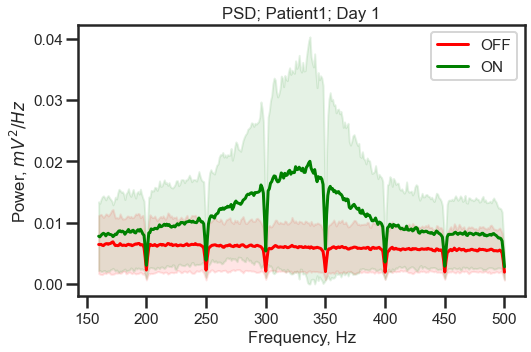

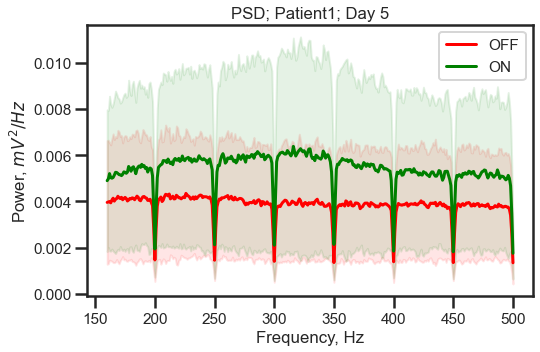

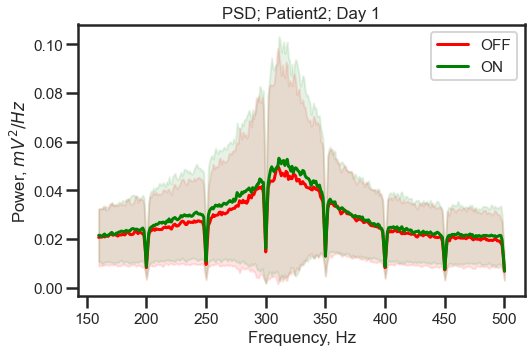

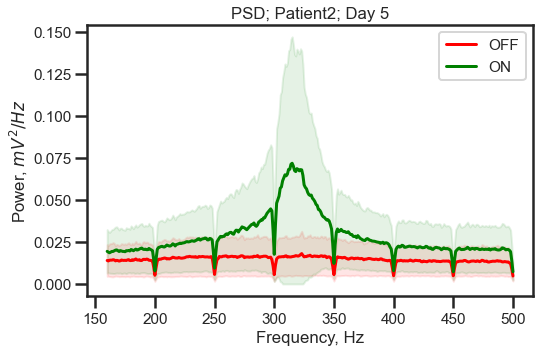

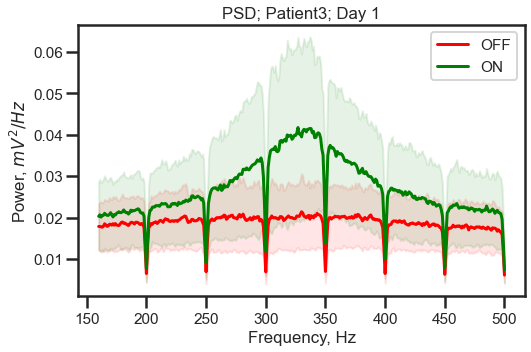

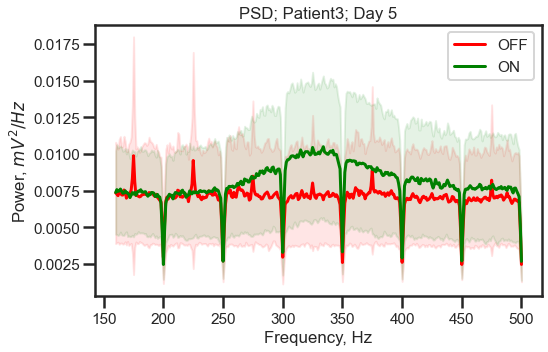

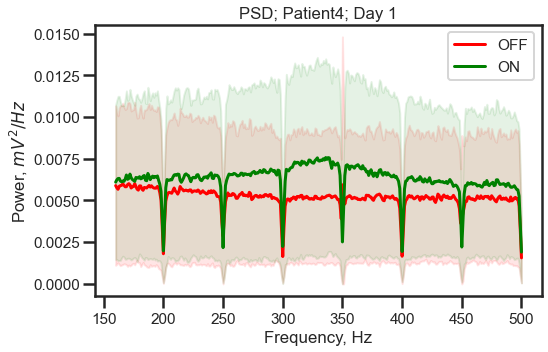

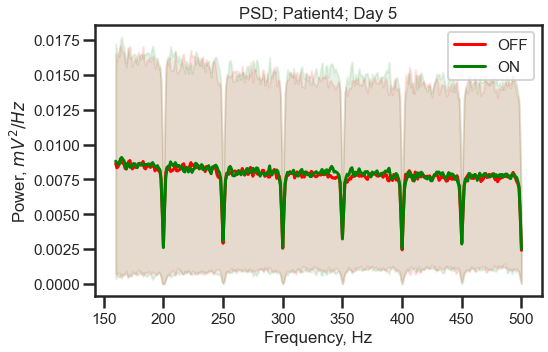

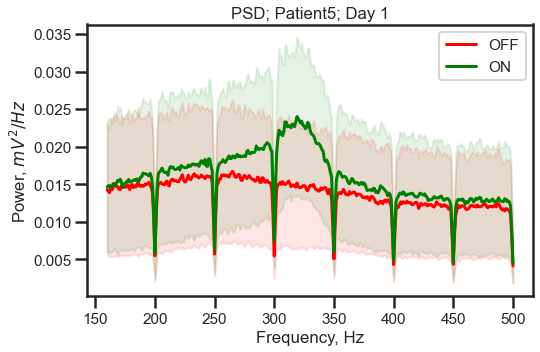

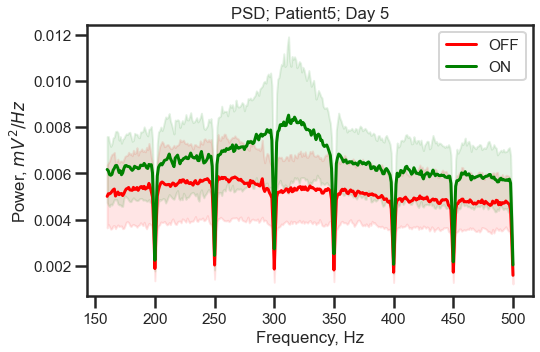

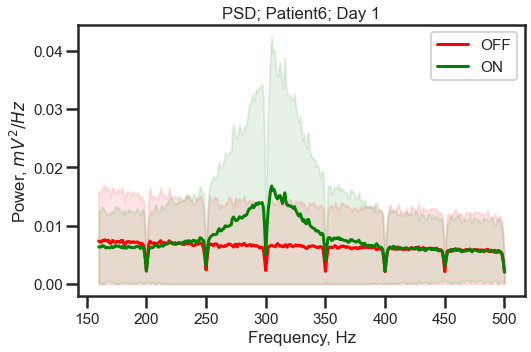

In [21]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as f:
    data_path = f.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON HFO by patient and day')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue
            
        f, psd_array_off, psd_array_on = get_psd_hfo_array_by_day(patient, day)
        psd_off_mean = psd_array_off.mean(axis=0)
        psd_off_std = psd_array_off.std(axis=0)

        psd_on_mean = psd_array_on.mean(axis=0)
        psd_on_std = psd_array_on.std(axis=0)

        fig, ax = plt.subplots(figsize=(8, 5))
        
        x = f
        y = psd_off_mean
        s = psd_off_std
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s
        
        ax.plot(x, y, color='red', label='OFF')
        ax.fill_between(x, lower, upper, color='red', alpha=.1)
        
        y = psd_on_mean
        s = psd_on_std
        lower = y - s
        lower[lower < 0] = 0
        upper = y + s

        ax.plot(x, y, color='green', label='ON')
        ax.fill_between(x, lower, upper, color='green', alpha=.1)


        ax.set_xlabel("Frequency, Hz")
        ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
        ax.legend()
        ax.set_title(f"PSD; {patient.name}; Day {day}")

        fig_name = f"PSD HFO OFF vs ON; {patient.name}; Day {day}.png"
        fig_path = os.path.join(save_path, fig_name)
        plt.savefig(fig_path, dpi=200, bbox_inches='tight')
        plt.show()

### Collective HFOs

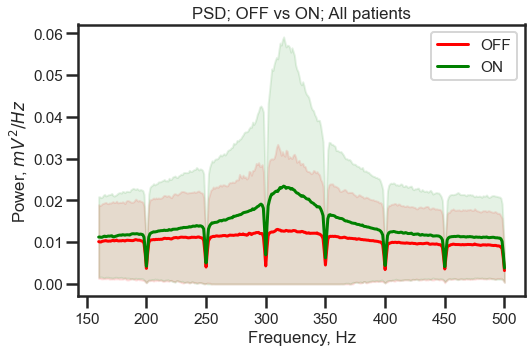

In [22]:
sns.set_context('poster', font_scale=0.7)
sns.color_palette('bright')


with open('path_data.txt', 'r') as file:
    data_path = file.readline()

save_path = os.path.join(data_path, 'im_common', 'spectra', 'OFF vs ON HFO all patients')

try:
    os.makedirs(save_path)
except:
    pass
    
patients = [p1, p2, p3, p4, p5, p6]
days = [1, 5]

psd_arrays_off = []
psd_arrays_on = []

for patient in patients:
    for day in days:
        if day == 5 and patient == p6:
            continue 
        f, psd_array_off, psd_array_on = get_psd_hfo_array_by_day(patient, day)
        psd_arrays_off.append(psd_array_off)
        psd_arrays_on.append(psd_array_on)
        
psd_arrays_off = np.array(psd_arrays_off).reshape(-1, len(f))
psd_arrays_on = np.array(psd_arrays_on).reshape(-1, len(f))

f, _, _ = get_psd_hfo_array_by_day(p3, 1)

psd_off_mean = psd_arrays_off.mean(axis=0)
psd_off_std = psd_arrays_off.std(axis=0)

psd_on_mean = psd_arrays_on.mean(axis=0)
psd_on_std = psd_arrays_on.std(axis=0)


fig, ax = plt.subplots(figsize=(8, 5))
        
x = f
y = psd_off_mean
s = psd_off_std
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='red', label='OFF')
ax.fill_between(x, lower, upper, color='red', alpha=.1)

y = psd_on_mean
s = psd_on_std
lower = y - s
lower[lower < 0] = 0
upper = y + s

ax.plot(x, y, color='green', label='ON')
ax.fill_between(x, lower, upper, color='green', alpha=.1)


ax.set_xlabel("Frequency, Hz")
ax.set_ylabel(r"Power, $mV^2/Hz$", rotation=90)
ax.legend()
ax.set_title(f"PSD; OFF vs ON; All patients")

fig_name = f"PSD HFO OFF vs ON; All patients - normalized.png"
fig_path = os.path.join(save_path, fig_name)
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
plt.show()